* pip install spotipy matplotlib requests pandas python-dotenv seaborn beautifulsoup4

In [ ]:
import spotipy
import os
import pprint
import pandas as pd
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
from collections import Counter


In [ ]:
load_dotenv()

In [ ]:
#cache_path = os.path.join(os.getcwd(), "spotify_cache")

In [ ]:
# auth and token
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id = os.getenv('SPOTIFY_CLIENT_ID'),
    client_secret = os.getenv('SPOTIFY_CLIENT_SECRET'),
    redirect_uri='http://localhost:8000/callback',
    scope='user-top-read, playlist-read-private',
    #cache_path=cache_path
))

## _clean dates fucntion_

In [ ]:
# clean dates
# len() - str return int
# apply
def date_clean(date):
    if isinstance(date, str) and len(date) == 4 and date.isdigit():
        return int(date)
    elif isinstance(date, str):
        return pd.to_datetime(date, errors='coerce').year
    return date


# _get wiki function_

In [ ]:
# get 'Genres' without slice or indices

def get_genres(artist_name):
    artist_name = artist_name.replace(" ", "_")

    url = f'https://en.wikipedia.org/wiki/{artist_name}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    table = soup.find("table", class_="infobox")
    if not table:
        return None
    
    for row in table.find_all('tr'):
        heading = row.find('th')

        if heading and 'Genres' in heading.text:
            data = row.find('td')
            genres = [li.text.strip() for li in data.find_all('li')]

            # ASK CHAPGPT TO CLEAN THE [5] ETC FROM THE STRING
            # BECAUSE REGEX MAKES MY BRAIN HURT
            # MORE THAT TRYING TO LEARN C++ AND REACT AT THE SAME TIME
            # ...
            # YES I ONCE THOUGHT THAT WAS A GOOD IDEA......

            genres = [re.sub(r"\[\d+\]", "", genre) for genre in genres]

            if not genres:
                genres = data.text.strip().split(', ')

            return genres
    return None

pprint.pprint(get_genres('Frank Ocean'))

## _My Top Artists_

In [ ]:
# get artists

def get_artists(time_range='medium_term', limit=20):
    results = sp.current_user_top_artists(time_range=time_range, limit=limit)
    artists = []

    for item in results['items']:
        genres = item.get('genres')
        artists.append({
            'name': item['name'],
            'followers': item['followers']['total'],
            'genres': ', '.join(item['genres']),
            'popularitty': item['popularity'],
        })
    df = pd.DataFrame(artists)

    # add other for empty genre lists
    df['Genres'] = df['genres'].apply(lambda x: x if x else 'other')

    return df



In [ ]:
my_artists_df = get_artists()

In [ ]:
cleaned_df = my_artists_df.drop('genres', axis=1)

cleaned_df.rename(columns={'popularitty': 'popularity'}, inplace=True)

my_artists_cleaned = cleaned_df

### _adding wiki scrape genres_

In [ ]:
#artists with other

for index, row in my_artists_cleaned[my_artists_cleaned['Genres'] == 'other'].iterrows():
    artist_name = row['name']

    new_genres = get_genres(artist_name)

    # got the list??
    if new_genres:
        my_artists_cleaned.at[index, 'Genres'] = ', '.join(new_genres)
    else:
        print(f'None found for {artist_name}')

In [ ]:
my_artists_cleaned.head()

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(my_artists_cleaned['name'], my_artists_cleaned['popularity'], color='skyblue')
plt.title('My Top Artists Popularity')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

## _my top genres in top artists_

In [ ]:

my_genres = [genre for sublist in cleaned_df['Genres'].str.split(', ') for genre in sublist]
genre_count = Counter(my_genres)
labels, sizes = zip(*genre_count.most_common(10))


In [ ]:

plt.figure(figsize=(12,6))
sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette='colorblind')
plt.xlabel("Count")
plt.ylabel("Genre")
plt.title('My Top Genres', fontsize=10)
plt.show()


## top tracks from top artists

In [ ]:
#my_artists_df['name']

In [ ]:
def tracks_from_artists(my_artists_df, time_range='medium_term', limit=50):
    results = sp.current_user_top_tracks(time_range=time_range,  limit=limit)
    tracks = []
    
    # print raw
    
    #print("Raw top tracks fetched:")
    #for item in results['items']:
    #    print(item['name'], "by", [artist['name'] for artist in item['artists']])
    
    #grab top artist names
    top_artist_names = set(my_artists_df['name'])
    
    for item in results['items']:
        artist_per_track = [artist['name'] for artist in item['artists']]

        if any(artist in top_artist_names for artist in artist_per_track):
            tracks.append({
                'track name': item['name'],
                'artists': ', '.join(artist_per_track),
                'album': item['album']['name'],
                'release': item['album']['release_date'],
                'track id': item['id'],
                'popularity': item['popularity']
            })
            
    tracks_df = pd.DataFrame(tracks)
    return tracks_df

### Why use a set instead of a list? - refresher from chatgpt

* Faster lookups: Checking membership in a set (O(1) average time) is much faster than searching in a list(O(n)).
* Avoids duplicates: A set automatically removes duplicate artist names.
* Better performance: If you have 50 top tracks, each with multiple artists, checking each one against a list of 20 top artists would be O(50 × 20) = 1000 checks. With a set, it remains O(50).

🌟 TLDR:
Using set(df_artists['Name']) ensures faster filtering when checking if a track's artist is in your top artists. 🚀

In [ ]:
my_top_tracks_from_top_artists_df = tracks_from_artists(my_artists_df)
my_top_tracks_from_top_artists_df['release'] =my_top_tracks_from_top_artists_df['release'].apply(date_clean)
my_top_tracks_from_top_artists_df.head()


# top tracks

In [ ]:
# get top tracks

def get_tracks(time_range='medium_term', limit=20):
    results = sp.current_user_top_tracks(time_range=time_range, limit=limit)
    t_tracks = []

    for item in results['items']:
        track_artists = [artist['name'] for artist in item['artists']]
        t_tracks.append({
            'track name': item['name'],
            'artists': ', '.join(track_artists),
            'album': item['album']['name'],
            'release': item['album']['release_date'],
            'track id': item['id'],
            'popularity': item['popularity']
        })
    top_tracks_df = pd.DataFrame(t_tracks)
    return top_tracks_df

In [ ]:
my_tracks_df = get_tracks()
my_tracks_df['release'] = my_tracks_df['release'].apply(date_clean)
my_tracks_df.head()


### merge my_top_tracks and my_top_tracks_from_top_artists_df

In [ ]:
all_top_tracks = pd.concat([my_tracks_df, my_top_tracks_from_top_artists_df]).reset_index(drop=True).drop_duplicates(subset=['track id'])

* want - to visualise the years my top tracks span or move through...
* need:
    * clean the release dates for yyyy
    * find the best choices to visualise 

In [ ]:

all_top_tracks['release'] = all_top_tracks['release'].apply(date_clean)


In [ ]:
all_top_tracks.head()

# playlists

### get all

In [ ]:
def get_playlists():
    results = sp.current_user_playlists()
    all_playlists = []

    while results:
        for playlist in results['items']:
            all_playlists.append({
                "playlist_name": playlist["name"],
                "total_tracks": playlist["tracks"]["total"],
                "playlist_id": playlist["id"]
            })
        # pagination
        if results["next"]:
            results = sp.next(results)
        else:
            break
    
    all_playlists = pd.DataFrame(all_playlists)
    return all_playlists


In [ ]:
my_playlists = get_playlists()
my_playlists.head()

* loop through tracks
    * for id in myplaylists
    * sp.playlisttracks(id)


In [ ]:
def get_playlist_tracks(my_playlists, limit=50):
    playlist_tracks = []

    for playlist_id, playlist_name in zip(my_playlists['playlist_id'], my_playlists['playlist_name']): #zip loops through the iterations???
        results = sp.playlist_tracks(playlist_id, limit=limit)  # Get tracks from the playlist

        for item in results['items']:
            track = item.get('track') 
            
            if track:  # 
                playlist_tracks.append({
                    'track_name': track['name'],
                    'artists': ', '.join([artist['name'] for artist in track['artists']]),
                    'album': track['album']['name'],
                    'release_year': track['album']['release_date'],
                    'track_id': track['id'],
                    'playlist name': playlist_name,
                    'playlist_id': playlist_id,
                    'popularity': track['popularity']
                })
    

    tracks_df = pd.DataFrame(playlist_tracks)

    return tracks_df

In [ ]:

my_tracks_from_playlists = get_playlist_tracks(my_playlists)

#my_tracks_from_playlists.drop_duplicates(subset=['track_id'], keep='first', inplace=True) # modified for finding most listened playlists - duplicated dropped for create_playlist.py

my_tracks_from_playlists['release_year'] = my_tracks_from_playlists['release_year'].apply(date_clean)

my_tracks_from_playlists.rename(columns={'track_name': 'track name', 'release_year': 'release year', 'track_id': 'track id', 'playlist_id': 'playlist id'}, inplace=True)

In [ ]:
my_tracks_from_playlists.head()

## convert to csv for creat_paylist script

In [ ]:
my_tracks_from_playlists.to_csv('my_playlist_tracks.csv')

# * _which albums occur across top tracks and playlists?_

* albums [] - if album in all_top_tracks and album in my_tracks_from_playlists: albums.append(aalbum, artist) - print albums ???


In [ ]:
#iitterrows

# use set to remove duplicates - for now i only want to see a list - so, list(set(albums))??

In [ ]:
albums = []

#loop through all tracks
for index1, row1 in all_top_tracks.iterrows():
    album1 = row1['album']
    artist1 = row1['artists']

    artist1 = artist1.split(',')[0] 
        
    if album1 in my_tracks_from_playlists['album'].values:
        albums.append((album1, artist1))

albums = list(set(albums))

pprint.pprint(albums)

## _add playlist id to mytracksfromplaylists to determine which playlist tracks are pulled from_ 
    * _need to bring back duplicates_
    

In [152]:
matches = all_top_tracks[all_top_tracks['track id'].isin(my_tracks_from_playlists['track id'])]['track name'].tolist()
pprint.pprint(matches)

['Silencer',
 'Pink + White',
 'Big eye',
 'Super Rich Kids',
 'You Gotta Be',
 'Combien de temps',
 'Antidote',
 'Weird Fishes / Arpeggi',
 'Self Control',
 'Mad (feat. Lil Wayne)',
 'My Head Explodes',
 'Cranes in the Sky',
 "Swan Lake, Op. 20, TH.12 / Act 2: No. 13e Danse des cygnes: Pas d'action: "
 'Odette et le prince/Deuxième danse de la reine des cygnes (Andante)',
 'La vita nuova']


In [153]:
track_playlist_matches = all_top_tracks[all_top_tracks['track id'].isin(my_tracks_from_playlists['track id'])].merge(my_tracks_from_playlists[['track id','playlist name', 'playlist id']], on='track id', how='left')

track_playlist_matches.drop(columns=['popularity', 'album', 'release'], axis=1)



,track name,artists,track id,playlist name,playlist id
0,Silencer,Dub War,1premcRnMNh9KvM7WWtgz5,the dailies,3kjzy5R1zPdnid2TYUQd2j
1,Pink + White,Frank Ocean,3xKsf9qdS1CyvXSMEid6g8,Chill,4NHOoP5BGZbYrWohyaJJDW
2,Big eye,Christine and the Queens,0fGbCVPP41cReDwIAuOORJ,Hmmm,13km7JNQUh5DRGV9QexgpI
3,Big eye,Christine and the Queens,0fGbCVPP41cReDwIAuOORJ,the dailies,3kjzy5R1zPdnid2TYUQd2j
4,Super Rich Kids,"Frank Ocean, Earl Sweatshirt",0725YWm6Z0TpZ6wrNk64Eb,the dailies,3kjzy5R1zPdnid2TYUQd2j
5,You Gotta Be,Des'ree,6CU0zWIWVTEnmWpSjVHM93,the dailies,3kjzy5R1zPdnid2TYUQd2j
6,Combien de temps,"Christine and the Queens, Rahim Redcar",61efs5Och14QW9lspob2or,Hmmm,13km7JNQUh5DRGV9QexgpI
7,Combien de temps,"Christine and the Queens, Rahim Redcar",61efs5Och14QW9lspob2or,Chill,4NHOoP5BGZbYrWohyaJJDW
8,Antidote,Orion Sun,1NlGXcWeUSe1s3IgRKcqmB,Hmmm,13km7JNQUh5DRGV9QexgpI
9,Weird Fishes / Arpeggi,Radiohead,4wajJ1o7jWIg62YqpkHC7S,the dailies,3kjzy5R1zPdnid2TYUQd2j


### _count amount of top tracks per playlist_

In [154]:
top_playlists = track_playlist_matches['playlist name'].value_counts()

top_playlists

playlist name
the dailies    6
Chill          6
Hmmm           5
🎻              1
Name: count, dtype: int64

* _great. this was the expected output. i mostly listen to those top 2 playlists else, song radios._
* _next, plot_

c:\Users\AARON\Desktop\DataSciFinal\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


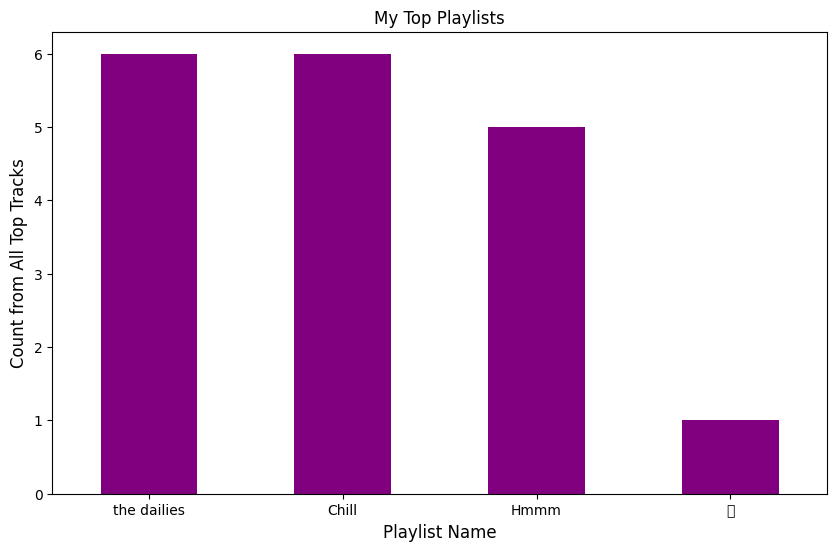

In [155]:
# my most listened to playlists from all_top_tracks count

plt.figure(figsize=(10, 6))
top_playlists.plot(kind='bar', color='purple')

plt.title('My Top Playlists')
plt.xlabel('Playlist Name', fontsize=12)
plt.ylabel('Count from All Top Tracks', fontsize=12)

plt.xticks(rotation=0, ha='center', fontsize=10)

plt.show()